In [1]:
# import packages we need to use
import scipy.stats
import numpy as np
import math
import pandas as pd
from matplotlib import pyplot as plt
from ipywidgets import widgets
import plotly.graph_objects as go

In [2]:
# Preparing data

# Confirmed cases
link1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv';
# Deaths
link2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv';

#dropping unnecessary variables and aggregating by state:
def trimedData(link):
    df =  pd.read_csv(link,sep=',',header=0)
    df = df[df.iso3 =='USA']
    df = df[df.Lat > 0.0]; #getting rid of some "unassigned" locations
    df = df.drop(['UID', 'FIPS', 'Admin2','iso2', 'iso3', 'code3','Lat', 'Long_', 'Combined_Key', 'Country_Region'], axis=1);
    return df.groupby(['Province_State']).sum()

cnfStates = trimedData(link1);
dthStates = trimedData(link2);

In [3]:
# new class definition

class State: 
    def __init__(self, name, buffer, lag):
        self.name = name
        self.buffer = buffer
        self.lag = lag
        self.confirmed = []
        self.deaths = []
        self.dates = []
        self.nobs = 0
    
    def create(self):        
        first = self.buffer
        last = cnfStates.shape[1]
        self.nobs = last - first 
        self.confirmed = (cnfStates.loc[self.name][first:last].to_numpy()
                          - cnfStates.loc[self.name][first-self.lag:last-self.lag].to_numpy())/self.lag
        self.deaths = (dthStates.loc[self.name][first:last].to_numpy() 
                       - dthStates.loc[self.name][first-self.lag:last-self.lag].to_numpy())/self.lag
        self.dates = cnfStates.columns[first:last]
        
    def show(self):
        fig = go.Figure()

        fig.add_trace(go.Scatter(
            x=self.dates,      
            y=self.confirmed,
            name="Confirmed"
        ))

        fig.add_trace(go.Scatter(
    
            x=self.dates,    
            y=self.deaths,
            name="Deaths",
            yaxis="y2"
        ))
        
        fig.update_layout(
            xaxis=dict(
                domain=[0.06, 0.94]
            ),
            yaxis=dict(
                title="Confirmed",
                titlefont=dict(
                    color="#1f77b4"
                ),
                tickfont=dict(
                    color="#1f77b4"
                ),
                side="left"
            ),
            yaxis2=dict(
                title="Deaths",
                titlefont=dict(
                    color="#ff7f0e"
                ),
                tickfont=dict(
                    color="#ff7f0e"
                ),
                anchor="free",
                overlaying="y",
                side="right",
                position=0.95
            )
        )
        
        fig.update_layout(
        title_text=self.name,
        width=800,
        )
        
        fig.show()


In [4]:
initialBuffer = 60
smoothingLag = 7

In [5]:
pa = State('Pennsylvania',initialBuffer,smoothingLag)
pa.create()

In [6]:
fl = State('Florida',initialBuffer,smoothingLag)
fl.create()

In [7]:
il = State('Illinois',initialBuffer,smoothingLag)
il.create()

In [8]:
nc = State('North Carolina',initialBuffer,smoothingLag)
nc.create()

In [9]:
ny = State('New York',initialBuffer,smoothingLag)
ny.create()

In [10]:
tx = State('Texas',initialBuffer,smoothingLag)
tx.create()

In [11]:
ca = State("California",initialBuffer,smoothingLag)
ca.create()

In [12]:
az = State("Arizona",initialBuffer,smoothingLag)
az.create()

In [13]:
oh = State("Ohio",initialBuffer,smoothingLag)
oh.create()

In [14]:
mydict = {"PA" : pa,
          "FL" : fl,
          "IL" : il,
          "NY" : ny,
          "NC" : nc,
          "TX" : tx,
          "CA" : ca,
          "AZ" : az,
          "OH" : oh}
     

# Assign an empty figure widget with two traces
trace1 = go.Scatter(x=pa.dates, y=pa.confirmed, opacity=0.75, name='Confirmed')
trace2 = go.Scatter(x=pa.dates, y=pa.deaths   , opacity=0.75, name='Deaths')
fig = go.FigureWidget(#data=[trace1, trace2],
                    layout=go.Layout(
                        title=dict(
                            text=pa.name
                        )
                    ))

fig.add_trace(go.Scatter(
    x=pa.dates,      
    y=pa.confirmed,
    name="Confirmed"
))

fig.add_trace(go.Scatter(

    x=pa.dates,    
    y=pa.deaths,
    name="Deaths",
    yaxis="y2"
))

fig.update_layout(
    title_text=pa.name,
    width=900,
    xaxis=dict(
        domain=[0.06, 0.94]
    ),
    yaxis=dict(
        title="Confirmed",
        titlefont=dict(
            color="#1f77b4"
        ),
        tickfont=dict(
            color="#1f77b4"
        ),
        side="left"
    ),
    yaxis2=dict(
        title="Deaths",
        titlefont=dict(
            color="#ff7f0e"
        ),
        tickfont=dict(
            color="#ff7f0e"
        ),
        anchor="free",
        overlaying="y",
        side="right",
        position=0.95
    )
)


states = widgets.Dropdown(
    options = sorted(list(mydict.keys())), 
    value = 'PA',
    description='States:',
)


def response(v):
    x  = mydict[states.value].dates
    y1 = mydict[states.value].confirmed
    y2 = mydict[states.value].deaths
    ti = mydict[states.value].name

    with fig.batch_update():
        fig.data[0].y = y1
        fig.data[1].y = y2

    fig.update_layout(
         title_text=ti,
     )

states.observe(response,names="value")   

container = widgets.HBox(children=[states])
widgets.VBox([container,
              fig   ])

In [15]:
## These might be needed before you run this notebook:

#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension --sys-prefix
#!pip install plotly

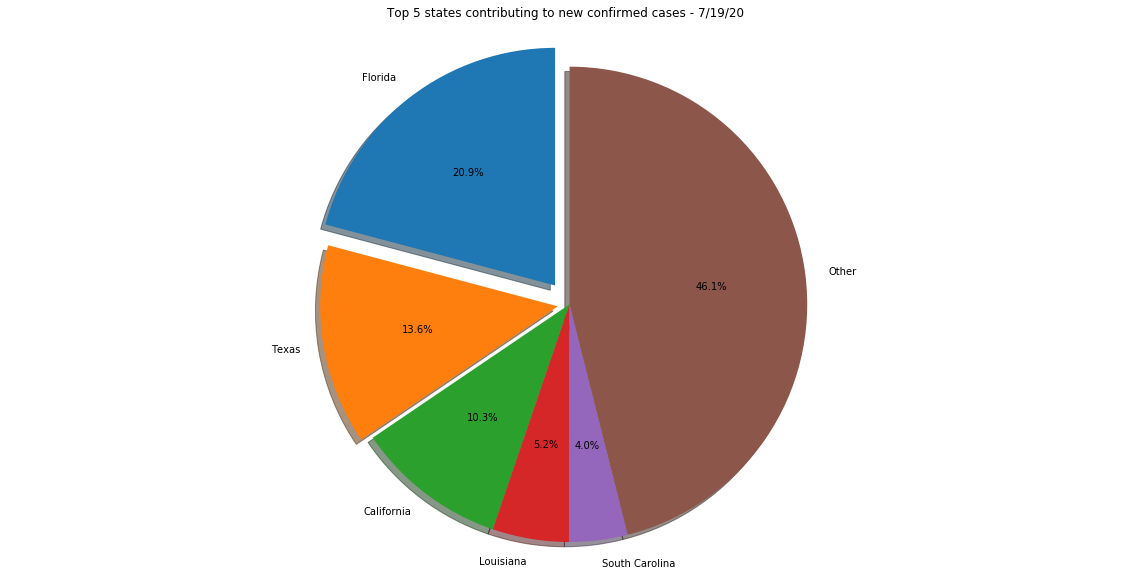

In [16]:
topStates = 5

lastDate = cnfStates.columns.values[-1]
beforeLastDate = cnfStates.columns.values[-2]

X = cnfStates

X['diff'] = X[lastDate] -X[beforeLastDate]
X.sort_values(by=['diff'],ascending=False,inplace=True)
o = np.sum(X['diff'][topStates:])


labels = np.append(X.index.values[0:topStates],'Other')
sizes = np.append(X['diff'].values[0:topStates], o)
#l = sizes.size
explode =  np.zeros(topStates+1)
explode[0] = 0.1
explode[1] = 0.05 # only "explode" the 1st and 2nd slices 

fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Top 5 states contributing to new confirmed cases - ' + lastDate)
plt.show()

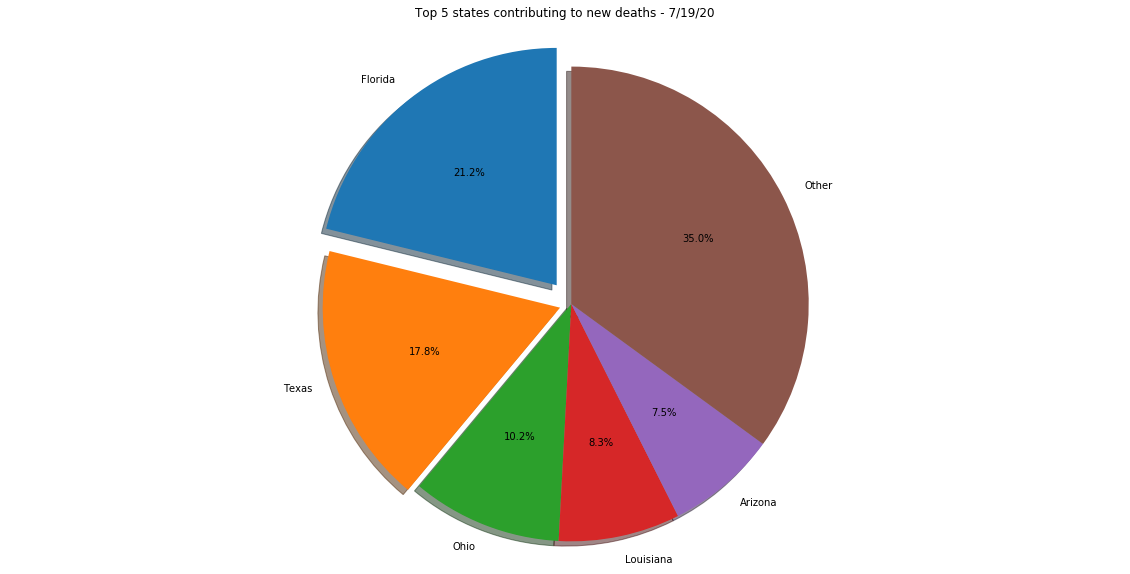

In [17]:
topStates = 5

lastDate = dthStates.columns.values[-1]
beforeLastDate = dthStates.columns.values[-2]

Y = dthStates


Y['diff'] = Y[lastDate] -Y[beforeLastDate]
Y.sort_values(by=['diff'],ascending=False,inplace=True)
o = np.sum(Y['diff'][topStates:])


labels = np.append(Y.index.values[0:topStates],'Other')
sizes = np.append(Y['diff'].values[0:topStates], o)
#l = sizes.size
explode =  np.zeros(topStates+1)
explode[0] = 0.1
explode[1] = 0.05 # only "explode" the 1st and 2nd slices 

fig1, ax1 = plt.subplots(figsize=(20, 10))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.set_title('Top 5 states contributing to new deaths - ' + lastDate)
plt.show()